## Can GPT4 Solve the ARC Challenge?
This notebook
- Seeks to use GPT-4 via zero-shot/few-shot prompt engineering to generate an output
- Uses Chain of Thought Reasoning as well as helper functions to let GPT-4 ground its answer
- Asks GPT-4 to generate the python code for its input-output description, and use it to check validity based on input/output pairs.
- Uses GPT-4s as expert agents with different biases and grounding to increase possibility of finding the appropriate abstraction space to solve the problem, and increase the diversity of possible generated code
- Uses an iterative loop in order to let GPT-4 learn from its mistakes (compile error), as well as take a step towards the goal output if incorrect solution (the generated output is now the input, and we ask it to generate a new input-output relationship)

Features
- Automated workflow to generate html pages based on task outputs
- Fully integrated ChatGPT API

In [1]:
import os
#API Keys
os.environ['OPENAI_API_TOKEN'] = 'YOUR_API_KEY_HERE'

In [2]:
import json
import ast
import hashlib
import matplotlib.pyplot as plt
import matplotlib.colors
import base64
from io import BytesIO
import numpy as np
import openai
import os
import copy
import traceback
import tiktoken
import re
from IPython.display import display, HTML, clear_output
from io import StringIO
from collections import defaultdict

def load_json_data(folder):
    json_files = [pos_json for pos_json in os.listdir(folder) if pos_json.endswith('.json')]
    data = {}
    for js in json_files:
        with open(os.path.join(folder, js)) as json_file:
            data[js] = json.load(json_file)
    return data

def plot_2d_grid(data):
    
    cvals  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    colors = ["black", "dodgerblue", "red", "lightgreen", "yellow", "grey", "magenta", "orange", "lightblue", "brown", "black"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    fig, axs = plt.subplots(len(data['test']), 3, figsize=(5, len(data['test']) * 3 * 0.7))
    axs = axs.reshape(-1, 3)  # Reshape axs to have 2 dimensions        
    
    # show grid
    for i, example in enumerate(data['test']):
        axs[i, 0].set_title(f'Test Input {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['input'])).shape
        axs[i, 0].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 0].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 0].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(string_to_array(example['input'])), cmap=cmap, vmin=0, vmax=9)
        
        axs[i, 1].set_title(f'Test Output {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['output'])).shape
        axs[i, 1].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 1].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 1].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(string_to_array(example['output'])), cmap=cmap, vmin=0, vmax=9)
        # plot gpt output if present
        if 'code_output' in example:
            axs[i, 2].set_title(f'GPT Output {i+1}')
            # display gridlines
            rows, cols = np.array(string_to_array(example['code_output'])).shape
            axs[i, 2].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
            axs[i, 2].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
            axs[i, 2].grid(True, which='minor', color='black', linewidth=0.5)
            axs[i, 2].set_xticks([]); axs[i, 2].set_yticks([])
            axs[i, 2].imshow(np.array(string_to_array(example['code_output'])), cmap=cmap, vmin=0, vmax=9)
        else:
            axs[i, 2].axis('off')
    plt.tight_layout()
    
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    
    plt.show()

    fig, axs = plt.subplots(len(data['train']), 3, figsize=(5, len(data['train']) * 3 * 0.7))
    axs = axs.reshape(-1, 3)  # Reshape axs to have 2 dimensions
    for i, example in enumerate(data['train']):
        axs[i, 0].set_title(f'Training Input {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['input'])).shape
        axs[i, 0].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 0].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 0].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 0].set_xticks([]); axs[i, 0].set_yticks([])
        axs[i, 0].imshow(np.array(string_to_array(example['input'])), cmap=cmap, vmin=0, vmax=9)
        
        axs[i, 1].set_title(f'Training Output {i+1}')
        # display gridlines
        rows, cols = np.array(string_to_array(example['output'])).shape
        axs[i, 1].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
        axs[i, 1].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
        axs[i, 1].grid(True, which='minor', color='black', linewidth=0.5)
        axs[i, 1].set_xticks([]); axs[i, 1].set_yticks([])
        axs[i, 1].imshow(np.array(string_to_array(example['output'])), cmap=cmap, vmin=0, vmax=9)
        if 'code_output' in example:
            axs[i, 2].set_title(f'GPT Output {i+1}')
            # display gridlines
            rows, cols = np.array(string_to_array(example['code_output'])).shape
            axs[i, 2].set_xticks(np.arange(cols + 1) - 0.5, minor=True)
            axs[i, 2].set_yticks(np.arange(rows + 1) - 0.5, minor=True)
            axs[i, 2].grid(True, which='minor', color='black', linewidth=0.5)
            axs[i, 2].set_xticks([]); axs[i, 2].set_yticks([])
            axs[i, 2].imshow(np.array(string_to_array(example['code_output'])), cmap=cmap, vmin=0, vmax=9)
        else:
            axs[i, 2].axis('off')
    plt.tight_layout()
    
    tmpfile = BytesIO()
    plt.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html += '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

    plt.show()
    
    # returns back in html format
    return html

In [3]:
def write_file(plot_html, task_name, res, error_msg, correct, test_correct, run, method_name="obj"):
    ''' Writes the output to a html file for easy reference next time '''
    # Create the HTML content
    html_content = f'''
    <html>
    <body>
    {plot_html}'''
    html_content += f'''<p> Training Set Solved: {correct}</p>\n'''
    html_content += f'''<p> Test Set Solved: {test_correct}</p>\n'''
    html_content += f'''<p>Compile Error: {error_msg != 'None'}</p>\n'''
    for key, value in res.items():
        html_content += f'''<p>{key}: {value}</p>\n'''
    html_content += '''
    </body>
    </html>
    '''
    
    # Overwrite if first run
    f = "w" if run == 0 else "a"
    with open(f"{task_name.split('.')[0]}_{method_name}.html", f) as file:
        file.write(html_content)

# Strict JSON

In [4]:
def strict_output(system_prompt, user_prompt, output_format, default_category = "", output_value_only = False,
                  model = 'gpt-3.5-turbo', temperature = 0.7, num_tries = 2, verbose = False, prompt_only = False):
    ''' Ensures that OpenAI will always adhere to the desired output json format. 
    Uses rule-based iterative feedback to ask GPT to self-correct.
    Keeps trying up to num_tries it it does not. Returns empty json if unable to after num_tries iterations.
    If output field is a list, will treat as a classification problem and output best classification category.
    Text enclosed within < > will generated by GPT accordingly'''

    # if the user input is in a list, we also process the output as a list of json
    list_input = isinstance(user_prompt, list)
    # if the output format contains dynamic elements of < or >, then add to the prompt to handle dynamic elements
    dynamic_elements = '<' in str(output_format)
    # if the output format contains list elements of [ or ], then we add to the prompt to handle lists
    list_output = '[' in str(output_format)
    
    # start off with no error message
    error_msg = ''
    
    for i in range(num_tries):
        
        output_format_prompt = f'''\nYou are to output the following in json format: {output_format}.
Do not use quotation marks ' or " within the fields unless it is required for the python code'''
        
        if list_output:
            output_format_prompt += f'''\nIf output field is a list, classify output into the best element of the list.'''
        
        # if output_format contains dynamic elements, process it accordingly
        if dynamic_elements: 
            output_format_prompt += f'''
Any text enclosed by < and > indicates you must generate content to replace it. Example input: Go to <location>, Example output: Go to the garden
Any output key containing < and > indicates you must generate the key name to replace it. Example input: {{'<location>': 'description of location'}}, Example output: {{school: a place for education}}'''

        # if input is in a list format, ask it to generate json in a list
        if list_input:
            output_format_prompt += '''\nGenerate a list of json, one json for each input element.'''
            
        if not prompt_only:
            # Use OpenAI to get a response
            response = openai.ChatCompletion.create(
              temperature = temperature,
              model=model,
              messages=[
                {"role": "system", "content": system_prompt + output_format_prompt + error_msg},
                {"role": "user", "content": str(user_prompt)}
              ]
            )

            res = response['choices'][0]['message']['content']
            
            # do some regex to remove unwanted single aprostrophes
            res = res.replace("'", '"')

            # replace any color name enclosed in double quotation marks to single quotation marks
            pattern = r'"([^\s"]+)"'
            res = re.sub(pattern, r"'\1'", res)

            # replace only single aprostrophe at the end of a word
            pattern = r'\b(?<!")(\w+)"\s'
            res = re.sub(pattern, r'\1 ', res)

            # add back double quotes to header names
            for key in list(output_format.keys()):
                pattern = fr"'({key})'"
                res = re.sub(pattern, r'"\1"', res)

            # ensure that we don't replace away aprostophes in text 
            res = re.sub(r"(\w)\"(\w)", r"\1'\2", res)

            # ensure that everything in python_program is substituted away
            pattern = r'"python_program"\s*:\s*"([^@]+)"}$'
            res = re.sub(pattern, lambda m: '"python_program": "'+m.group(1).replace('"', "'")+'"}', res)

            # replace any characters with a backslash away, except \n and \t
            pattern = r"(\\[^nt])"
            res = re.sub(pattern, "", res)

            # replace newline and tabs
            res = res.replace("\n", "\\n").replace("\t", "\\t")

        if verbose:
            print('System prompt:', system_prompt + output_format_prompt + error_msg)
            print('\nUser prompt:', str(user_prompt))
            if not prompt_only: print('\nGPT response:', res)
            
        if prompt_only:
            return '\n\nUser prompt:' + str(user_prompt) + '\n\nSystem prompt: '+ system_prompt + output_format_prompt + error_msg

        # try-catch block to ensure output format is adhered to
        try:
            output = json.loads(res)
            if isinstance(user_prompt, list):
                if not isinstance(output, list): raise Exception("Output format not in a list of json")
            else:
                output = [output]

            # check for each element in the output_list, the format is correctly adhered to
            for index in range(len(output)):
                for key in output_format.keys():
                    # unable to ensure accuracy of dynamic output header, so skip it
                    if '<' in key or '>' in key: continue
                    # if output field missing, raise an error
                    if key not in output[index]: raise Exception(f"{key} not in json output")
                    # check that one of the choices given for the list of words is an unknown
                    if isinstance(output_format[key], list):
                        choices = output_format[key]
                        # ensure output is not a list
                        if isinstance(output[index][key], list):
                            output[index][key] = output[index][key][0]
                        # output the default category (if any) if GPT is unable to identify the category
                        if output[index][key] not in choices and default_category:
                            output[index][key] = default_category
                        # if the output is a description format, get only the label
                        if ':' in output[index][key]:
                            output[index][key] = output[index][key].split(':')[0]

                # if we just want the values for the outputs
                if output_value_only:
                    output[index] = [value for value in output[index].values()]
                    # just output without the list if there is only one element
                    if len(output[index]) == 1:
                        output[index] = output[index][0]

            return output if list_input else output[0]

        except Exception as e:
            error_msg = f"\n\nResult: {res}\n\nError message: {str(e)}"
            print("An exception occurred:", str(e))
            print("Current invalid json format:", res)

    return {}

# Token Count function for OpenAI

In [5]:
def token_count(text="", model = "gpt-4"):
    ''' Takes in a given text and returns the number of tokens, plus the list of tokens '''
    encoding = tiktoken.encoding_for_model(model)
    token = encoding.encode(text)
    return len(token), [encoding.decode_single_token_bytes(t) for t in token]

# Utility functions for objects

In [6]:
def get_size(grid):
    ''' Returns the size of the grid in 2 axis '''
    return (len(grid), len(grid[0]))
def get_middle(coords):
    ''' Returns the middle of the coordinates '''
    x_sum, y_sum = 0, 0
    for (x,y) in coords:
        x_sum += int(x)
        y_sum += int(y)
    return (int(x_sum/len(coords)+0.5), int(y_sum/len(coords)+0.5))
def get_anchor(coords):
    ''' Returns the top left, and bottom right anchor of the shape '''
    min_x, min_y = 10000, 10000
    max_x, max_y = 0, 0
    for (x, y) in coords:
        min_x = min(x, min_x)
        min_y = min(y, min_y)
        max_x = max(x, max_x)
        max_y = max(y, max_y)
    return (min_x, min_y), (max_x, max_y)

def array_to_string(grid):
    # if grid is already in string form, just return it
    if isinstance(grid[0][0], str): return grid

    mapping = {0:'.',1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j'}
    newgrid = [[mapping[grid[i][j]] for j in range(len(grid[0]))] for i in range(len(grid))]
    return newgrid

def string_to_array(grid):
    # if grid is already in integer form, just return it
    if isinstance(grid[0][0], int): return grid

    mapping = {0:'.',1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j'}
    revmap = {v:k for k,v in mapping.items()}
    newgrid = [[revmap[grid[i][j]] for j in range(len(grid[0]))] for i in range(len(grid))]
    return newgrid

In [7]:
def get_pixel_coords(grid):
    ''' Gets the coords of all the pixel values '''
    pixel_coord = {}
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            for value in 'abcdefghij':
                if grid[row][col] == value:
                    if value in pixel_coord:
                        pixel_coord[value].append((row,col))
                    else:
                        pixel_coord[value] = [(row,col)]
    return dict(sorted(pixel_coord.items(), key = lambda x: -len(x[1])))

def obj_to_coords(obj):
    coords = []
    x, y = obj['tl']
    height, width = len(obj['grid']), len(obj['grid'][0])
    for i in range(height):
        for j in range(width):
            if obj['grid'][i][j] != '.':
                coords.append((x+i, y+j))
    return coords

def create_object(grid, coords):
    ''' Create an object based on the existing grid, and the coordinates of it '''
    (min_x, min_y), (max_x, max_y) = get_anchor(coords)
    newgrid = [['.' for _ in range(max_y-min_y+1)] for _ in range(max_x-min_x+1)]
    for (x, y) in coords:
        if grid[x][y]=='.':
            newgrid[x-min_x][y-min_y]='$'
        else:
            newgrid[x-min_x][y-min_y]=grid[x][y]
    return {'tl': (min_x, min_y), 'grid': newgrid}

In [8]:
assert get_pixel_coords([['a','a'],['d','f']])=={'a':[(0, 0),(0, 1)],'d':[(1, 0)],'f':[(1, 1)]}

## Helper Function
- Function to help GPT execute tasks

In [9]:
def get_objects(grid, diag = False, multicolor = False, by_row = False, by_col = False, by_color = False, more_info = True):
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    objects = []
    missing_color = False
    
    # check whether there is a missing color
    for each in grid:
        for cell in each:
            if cell == 'j': missing_color = True

    def is_valid(grid, row, col, value):
        # multicolor can return any cell as long as it is not visited and not a blank
        if multicolor:
            return 0 <= row < rows and 0 <= col < cols and (row, col) not in visited \
        and grid[row][col] != '.' and grid[row][col] != '$'
        else:  
            return 0 <= row < rows and 0 <= col < cols and (row, col) not in visited and grid[row][col] == value

    def dfs(grid, row, col, value):
        if is_valid(grid, row, col, value):
            visited.add((row, col))
            object_coords.add((row, col))
            
            if not by_row:
                dfs(grid, row - 1, col, value)  # up
                dfs(grid, row + 1, col, value)  # down
            if not by_col:
                dfs(grid, row, col - 1, value)  # left
                dfs(grid, row, col + 1, value)  # right
            if not by_row and not by_col and diag:
                dfs(grid, row - 1, col - 1, value)  # top-left diagonal
                dfs(grid, row - 1, col + 1, value)  # top-right diagonal
                dfs(grid, row + 1, col - 1, value)  # bottom-left diagonal
                dfs(grid, row + 1, col + 1, value)  # bottom-right diagonal
    
    # # if by color, we don't need to do dfs
    if by_color:
        pixels = get_pixel_coords(grid)
        for key, value in pixels.items():
            object_coords = value
            object_dict = create_object(grid, object_coords)
            if more_info:
                object_dict['size']=(len(object_dict['grid']),len(object_dict['grid'][0]))
                # object_dict['br']=(object_dict['tl'][0]+object_dict['size'][0]-1,object_dict['tl'][1]+object_dict['size'][1]-1)
                object_dict['cell_count']=len(object_coords)
                # object_dict['shape'] = generate_hash([['x' if cell != '.' else '.' for cell in row] for row in object_dict['grid']])
                object_dict['shape'] = [['x' if cell != '.' else '.' for cell in row] for row in object_dict['grid']]
            objects.append(object_dict)
            
    else:
        for row in range(rows):
            for col in range(cols):
                value = grid[row][col]
                if (row, col) not in visited:
                    if (value == '.' or value == 0): continue
                    object_coords = set()
                    dfs(grid, row, col, value)
                    object_dict = create_object(grid, object_coords)
                    if more_info:
                        object_dict['size']=(len(object_dict['grid']),len(object_dict['grid'][0]))
                        object_dict['cell_count']=len(object_coords)
                        # object_dict['shape'] = generate_hash([['x' if cell != '.' else '.' for cell in row] for row in object_dict['grid']])
                        object_dict['shape'] = [['x' if cell != '.' else '.' for cell in row] for row in object_dict['grid']]
                    objects.append(object_dict)

        
        # check whether there is the color 'j'. If don't have, then do inner objects
        if not missing_color:
            # do separate empty object list for all grids in identified objects
            multicolor = False
            new_objects = []
            for obj in objects:
                visited = set()
                newgrid = obj['grid']
                rows = len(newgrid)
                cols = len(newgrid[0])
                for row in range(rows):
                    for col in range(cols):
                        if (row, col) not in visited:
                            if newgrid[row][col] == '.':
                                object_coords = set()
                                dfs(newgrid, row, col, '.')
                                # check if we don't contain boundary coordinates
                                boundary = False
                                for x,y in object_coords:
                                    if x==0 or x==len(newgrid)-1 or y==0 or y==len(newgrid[0])-1:
                                        boundary = True
                                if boundary: continue
                                object_dict = create_object(newgrid, object_coords)
                                cur_x, cur_y = object_dict['tl']
                                base_x, base_y = obj['tl']
                                
                                object_dict['tl'] = (cur_x+base_x, cur_y+base_y)
                                if more_info:
                                    object_dict['size']=(len(object_dict['grid']),len(object_dict['grid'][0]))
                                    object_dict['cell_count']=len(object_coords)
                                     # object_dict['shape'] = generate_hash([['x' if cell != '.' else '.' for cell in row] for row in object_dict['grid']])
                                    object_dict['shape'] = [['x' if cell != '.' else '.' for cell in row] for row in object_dict['grid']]
                                new_objects.append(object_dict)
    
            objects.extend(new_objects)
    return objects

def combine_object(obj1, obj2):
    # if not an instance of object, create it
    if not isinstance(obj1, dict): obj1 = {'tl':(0,0), 'grid': obj1}
    if not isinstance(obj2, dict): obj2 = {'tl':(0,0), 'grid': obj2}
    grid = empty_grid(30, 30)
    grid = fill_grid(grid, obj1['tl'], obj1['grid'])
    grid = fill_grid(grid, obj2['tl'], obj2['grid'])
    obj_coords = obj_to_coords(obj1)
    obj_coords2 = obj_to_coords(obj2)
    obj_coords.extend(obj_coords2)
    return create_object(grid, obj_coords)
    
def tight_fit(grid):
    objects = get_objects(grid)
    obj = objects[0]
    for each in objects[1:]:
        obj = combine_object(obj, each)
    return obj['grid']
                               
def fill_grid(grid, tl, pattern): 
    x, y = tl
    if not isinstance(pattern, list): pattern = [[pattern]]
    for row in range(len(pattern)):
        for col in range(len(pattern[0])):
            if 0<=row+x<len(grid) and 0<=col+y<len(grid[0]): 
                if pattern[row][col] != '$':
                    grid[row+x][col+y] = pattern[row][col]
    return grid

def fill_object(grid, obj, align=False):
    if align: return obj['grid']
    return fill_grid(grid, obj['tl'], obj['grid'])

def empty_grid(row, col):
    grid = [['.' for _ in range(col)] for _ in range(row)]
    return grid

def crop_grid(grid, tl, br): 
    return [[grid[i][j] for j in range(tl[1],br[1]+1)] for i in range(tl[0],br[0]+1)]

def fill_between_coords(grid, coord1, coord2, value): 
    # fill up a point
    if coord1 == coord2:
        grid[coord1[0]][coord1[1]] = value
        return grid
    
    # fill up a line
    row_diff = coord1[0]-coord2[0]
    col_diff = coord1[1]-coord2[1]
    maxdist = max(abs(row_diff), abs(col_diff))
    height, width = len(grid), len(grid[0])
    for i in range(maxdist+1):
        row_pos, col_pos = coord1[0]-(i*row_diff)//maxdist, coord1[1]-(i*col_diff)//maxdist
        if 0<=row_pos<height and 0<=col_pos<width: grid[row_pos][col_pos] = value
    return grid
                               
def rotate_clockwise(grid, degree=90):
    newgrid = copy.deepcopy(grid)
    for i in range(degree//90):
        # Transpose the array
        transposed_grid = [[newgrid[j][i] for j in range(len(newgrid))] for i in range(len(newgrid[0]))]

        # Reverse each row of the transposed array
        newgrid = [row[::-1] for row in transposed_grid]
    return newgrid

def horizontal_flip(grid):
    return [row[::-1] for row in grid]

def vertical_flip(grid):
    return [row for row in grid[::-1]]

def fill_value(grid, pos, value):
    x, y = pos
    if x<0 or x>=len(grid) or y<0 or y>=len(grid[0]): return grid
    grid[x][y] = value
    return grid

def replace(grid, pattern1, pattern2):
    if not isinstance(pattern1, list) : pattern1 = [[pattern1]]
    if not isinstance(pattern2, list): pattern2 = [[pattern2]]
    height, width = len(pattern1), len(pattern1[0])
    for i in range(len(grid)-height+1):
        for j in range(len(grid[0])-width+1):
            if crop_grid(grid, (i,j), (i+height-1, j+width-1))==pattern1:
                grid = fill_grid(grid, (i,j), pattern2)
    return grid

def fill_rect(grid, tl, br, value):
    for row in range(tl[0], br[0]+1):
        for col in range(tl[1], br[1]+1):
            grid = fill_value(grid, (row, col), value)
    return grid

def fill_row(grid, row_num, value, start_col=0, end_col=30):
    for col_num in range(start_col, end_col+1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def fill_col(grid, col_num, value, start_row=0, end_row=30): 
    for row_num in range(start_row, end_row+1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def change_object_pos(obj,new_tl):
    obj['tl']=tl
    return obj

def change_object_color(obj, value):
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != '.':
                obj['grid'][row][col] = value
    return obj

def get_object_color(obj):
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != '.':
                return obj['grid'][row][col]
    return '.'

### Unit Tests

In [10]:
helper_functions = '''- get_objects(grid,diag=False,by_row=False,by_col=False,by_color=False,multicolor=False,more_info = True): 
Takes in grid, returns list of object dictionary: top-left coordinate of object ('tl'), 2D grid ('grid')
by_row views splits objects by grid rows, by_col splits objects by grid columns, by_color groups each color as one object, multicolor means object can be more than one color
Empty cells within objects are represented as '$'
If more_info is True, also returns size of grid ('size'), cells in object ('cell_count'), shape of object ('shape')
- get_pixel_coords(grid): Returns a dictionary, with the keys the pixel values, values the list of coords, in sorted order from most number of pixels to least
- empty_grid(row, col): returns an empty grid of height row and width col
- crop_grid(grid, tl, br): returns cropped section from top left to bottom right of the grid
- tight_fit(grid): returns grid with all blank rows and columns removed
- combine_object(obj_1, obj_2): returns combined object from obj_1 and obj_2. if overlap, obj_2 overwrites obj_1
- rotate_clockwise(grid, degree=90): returns rotated grid clockwise by a degree of 90, 180, 270 degrees
- horizontal_flip(grid): returns a horizontal flip of the grid
- vertical_flip(grid): returns a vertical flip of the grid
- replace(grid, grid_1, grid_2): replaces all occurences of grid_1 with grid_2 in grid
- get_object_color(obj): returns color of object. if multicolor, returns first color only
- change_object_color(obj, value): changes the object color to value
- fill_object(grid, obj, align=False): fills grid with object. If align is True, makes grid same size as object
- fill_row(grid, row_num, value, start_col=0, end_col=30): fills output grid with a row of value at row_num from start_col to end_col (inclusive)
- fill_col(grid, col_num, value, start_row=0, end_row=30): fills output grid with a column of value at col_num from start_row to end_row (inclusive)
- fill_between_coords(grid, coord_1, coord_2, value): fills line between coord_1 and coord_2 with value
- fill_rect(grid,tl,br,value): fills grid from tl to br with value. useful to create rows, columns, rectangles
- fill_value(grid, pos, value): fills grid at position with value
'''

assert get_objects([['a','a','a'],['a','.','a'],['a','a','a']],more_info=False)==[{'tl':(0, 0),'grid':[['a','a','a'],['a','.','a'],['a','a','a']]},{'tl':(1,1),'grid':[['$']]}]
assert get_pixel_coords([['a','a'],['d','f']])=={'a':[(0, 0),(0, 1)],'d':[(1, 0)],'f':[(1, 1)]}
assert empty_grid(3, 2)==[['.','.'], ['.','.'], ['.','.']]
assert crop_grid([['a','a','b'],['.','a','b']],(0, 0),(1, 1))==[['a','a'],['.','a']]
assert tight_fit([['.','.','.'],['.','a','.'],['.','.','.']])==[['a']]
assert combine_object({'tl':(0, 0),'grid':[['a','a'],['a','.']]},{'tl': (1, 1),'grid':[['f']]})=={'tl':(0, 0),'grid':[['a','a'],['a','f']]}
assert rotate_clockwise([['a','b'],['d','e']],90)==[['d','a'],['e','b']]
assert rotate_clockwise([['a','b'],['d','e']],270)==[['b','e'],['a','d']]
assert horizontal_flip([['a','b','c'],['d','e','f']])==[['c','b','a'], ['f','e','d']]
assert vertical_flip([['a','b','c'],['d','e','f']])==[['d','e','f'],['a','b','c']]
assert replace([['a','.'],['a','a']],[['a','a']],[['c','c']])==[['a','.'],['c','c']]
assert change_object_color({'tl':(0,0),'grid':[['a','.']]},'b')=={'tl':(0,0),'grid':[['b','.']]}
assert get_object_color({'tl':(0,0),'grid':[['a','.']]})=='a'
assert fill_object([['.','.'],['.','.']],{'tl':(0, 1),'grid':[['c'],['c']]})==[['.','c'],['.','c']]
assert fill_value([['.','a'],['.','a']],(1,1),'b')==[['.','a'],['.','b']]
assert fill_row([['a','a'],['c','a']],0,'b')==[['b','b'],['c','a']]
assert fill_col([['a','a'],['c','a']],0,'b')==[['b','a'],['b','a']]
assert fill_rect([['a','a'],['c','a']],(0,0),(1,1),'b')==[['b','b'],['b','b']]
assert fill_between_coords([['.','.']],(0,0),(0,1),'a')==[['a','a']]

## Conditional Functions
- Functions to help with deciding when to use helper functions

In [11]:
def object_contains_color(obj, value):
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] == value:
                return True
    return False

def on_same_line(coord1, coord2, line_type):
    '''Returns True/False if coord1 is on the same line as coord2. line_type can be one of ['row', 'col', 'diag']'''
    if line_type == 'row': return coord1[0] == coord2[0]
    if line_type == 'col': return coord1[1] == coord2[1]
    if line_type == 'diag': return coord1[0]-coord2[0] == coord1[1]-coord2[1]
    return False

In [12]:
conditional_functions = '''
object_contains_color(obj, value): returns True/False if object contains a certain value
on_same_line(coord_1, coord_2): Returns True/False if coord_1 is on the same line as coord_2. line_type can be one of ['row', 'col', 'diag']
'''

assert object_contains_color({'tl':(0,0),'grid':[['a']]},'a')==True
assert on_same_line((1,1),(1,2),'row')==True
assert on_same_line((1,1),(2,1),'col')==True
assert on_same_line((1,1),(2,2),'diag')==True

### Unit Tests

## Load the JSON files

- Download from https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip

In [13]:
if not os.path.exists('ARC-800-tasks'):
    !wget https://lab42.global/wp-content/uploads/2022/08/ARC-800-tasks.zip 
    !unzip ARC-800-tasks.zip -d ./ARC-800-tasks

In [14]:
# load the json files

# download the data from 
folder = 'ARC-800-tasks/training'
myjson_train = load_json_data(folder)
file_names_train = list(myjson_train.keys())

folder = 'ARC-800-tasks/evaluation'
myjson_eval = load_json_data(folder)
file_names_eval = list(myjson_eval.keys())

## Get the JSON for the GPT input
- Limit the problems to those that can fit into context length of 8k tokens (to be safe, 3k tokens) of GPT4

In [15]:
good_index_train = []
good_index_eval = []
max_token = 3000
model = 'gpt-4'

for index in range(800):
    correct = False
    test_correct = False
    if index < 400:
        task_name = file_names_train[index]
        json_task = copy.deepcopy(myjson_train[task_name])

    else:
        task_name = file_names_eval[index-400]
        json_task = copy.deepcopy(myjson_eval[task_name])

    for each in json_task['train']+json_task['test']:
        # convert to string representation
        for field in ['input', 'output', 'code_output']:
            if field in each: each[field] = array_to_string(each[field])
        each['input_grid_size'] = get_size(each['input'])
        each['input_objects'] = get_objects(each['input'], more_info = False)
        # each['input_pixel_coords'] = get_pixel_coords(each['input'])
        each['output_grid_size'] = get_size(each['output'])
        each['output_objects'] = get_objects(each['output'], more_info = False)
        # each['output_pixel_coords'] = get_pixel_coords(each['output'])
        if 'code_output' in each:
            each['code_output_grid_size'] = get_size(each['code_output'])
            each['code_output_objects'] = get_objects(each['code_output'], more_info = False)
            # each['code_output_pixel_coords'] = get_pixel_coords(each['code_output'])

    preamble = '''You are given a series of inputs and output pairs. 
The values from 'a' to 'j' represent different colors. '.' is a blank cell.
For example, [['.','a','.'],['.','.','b']] represents a 2 row x 3 col grid with color a at position (1,0) and color b at position (2,1).
Coordinates are 2D positions (row, col), row representing row number, col representing col number, with zero-indexing.
Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation.

Each of the input-output relation can be done with one or more helper functions chained together. 
Some relations require other functions, which you will need to come up with yourself.
Objects are tight-fitted grids (no empty row or column) with a top left coordinate, which can be used for easy manipulation of multiple coordinates.
You can create your own objects by just creating a dictionary with 'tl' and 'grid'
You can change an object's position by using 'tl' and its composition using 'grid'.
You should start each program by copying input grid or empty_grid or crop_grid of desired output size.
Then, fill the grid by using the fill helper functions.
If you use the fill functions with a '.' value, it is equivalent to removing parts of the grid.

Helper functions:\n'''+ helper_functions + '''\n
assert get_objects([['a','a','a'],['a','.','a'],['a','a','a']],more_info=False)==[{'tl':(0, 0),'grid':[['a','a','a'],['a','.','a'],['a','a','a']]},{'tl':(1,1),'grid':[['$']]}]
assert get_pixel_coords([['a','a'],['d','f']])=={'a':[(0, 0),(0, 1)],'d':[(1, 0)],'f':[(1, 1)]}
assert empty_grid(3, 2)==[['.','.'], ['.','.'], ['.','.']]
assert crop_grid([['a','a','b'],['.','a','b']],(0, 0),(1, 1))==[['a','a'],['.','a']]
assert tight_fit([['.','.','.'],['.','a','.'],['.','.','.']])==[['a']]
assert combine_object({'tl':(0, 0),'grid':[['a','a'],['a','.']]},{'tl': (1, 1),'grid':[['f']]})=={'tl':(0, 0),'grid':[['a','a'],['a','f']]}
assert rotate_clockwise([['a','b'],['d','e']],90)==[['d','a'],['e','b']]
assert rotate_clockwise([['a','b'],['d','e']],270)==[['b','e'],['a','d']]
assert horizontal_flip([['a','b','c'],['d','e','f']])==[['c','b','a'], ['f','e','d']]
assert vertical_flip([['a','b','c'],['d','e','f']])==[['d','e','f'],['a','b','c']]
assert replace([['a','.'],['a','a']],[['a','a']],[['c','c']])==[['a','.'],['c','c']]
assert change_object_color({'tl':(0,0),'grid':[['a','.']]},'b')=={'tl':(0,0),'grid':[['b','.']]}
assert get_object_color({'tl':(0,0),'grid':[['a','.']]})=='a'
assert fill_object([['.','.'],['.','.']],{'tl':(0, 1),'grid':[['c'],['c']]})==[['.','c'],['.','c']]
assert fill_value([['.','a'],['.','a']],(1,1),'b')==[['.','a'],['.','b']]
assert fill_row([['a','a'],['c','a']],0,'b')==[['b','b'],['c','a']]
assert fill_col([['a','a'],['c','a']],0,'b')==[['b','a'],['b','a']]
assert fill_rect([['a','a'],['c','a']],(0,0),(1,1),'b')==[['b','b'],['b','b']]
assert fill_between_coords([['.','.']],(0,0),(0,1),'a')==[['a','a']]

Each helper function can be conditional. The conditions can be:
- by attribute, such as shape, color, position, size, cell number of object
- the condition can be an attribute on all objects, for instance, objects with the most common or least common value, or objects with the most or least common shape
- by position of pixels, such as row or column
- by neighbouring cell types or values

There are some conditional functions to help you.'''
    preamble += conditional_functions +\
    '''
assert object_contains_color({'tl':(0,0),'grid':[['a']]},'a')==True
assert on_same_line((1,1),(1,2),'row')==True
assert on_same_line((1,1),(2,1),'col')==True
assert on_same_line((1,1),(2,2),'diag')==True
'''

    output_format = {"reflection": "reflect on the answer",     
"pixel_changes": "describe the changes between the input and output pixels, focusing on movement or pattern changes",
"object_changes": "describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count",
"helper_functions": "list any relevant helper_functions for this task",
"overall_pattern": "describe the simplest input-output relationship for all input-output pairs",
"program_instructions": "Plan how to write the python function and what helper functions and conditions to use",
"python_program": "Python function named 'transform_grid' that takes in a 2D grid and generates a 2D grid. Output as a string in a single line with \n and \t."}

    new_json_task = copy.deepcopy(json_task['train'])
    user_prompt = str(new_json_task).replace(', ',',').replace(' ','')
    res = strict_output(system_prompt = preamble, user_prompt = user_prompt, output_format = output_format, model = model, prompt_only = True)

    # count tokens for input
    num_tokens, token_list = token_count(str(res))
    if num_tokens<max_token:
        if index < 400:
            good_index_train.append(index)
        else:
            good_index_eval.append(index)
print(f"Total examples below {max_token} tokens for train: {len(good_index_train)}")
print(f"Total examples below {max_token} tokens for eval: {len(good_index_eval)}")

Total examples below 3000 tokens for train: 111
Total examples below 3000 tokens for eval: 30


# Do overall automated flow - objects
- Set the number of loops with the environment (num_trials: default 3)
- Set the parameters of the abstraction view - object (16 sub configurations) or pixel
- also set if you want to hide the original grid (hide_grid), or to convert cell 0 (black cell) to another color (missing_color)

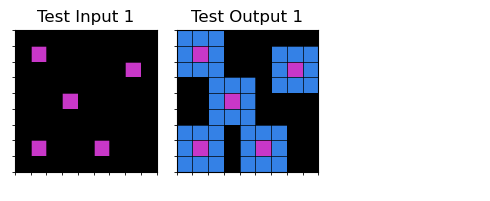

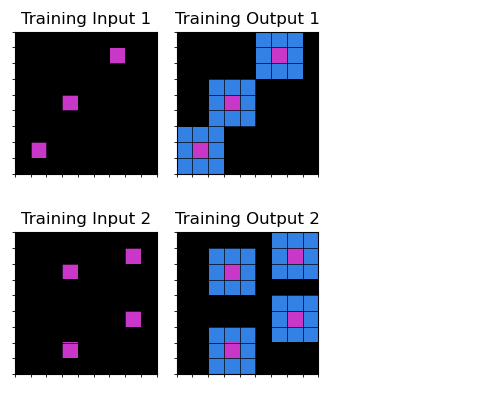

In [16]:
num_trials = 3 # number of times to do environmental feedback / compile error correction

ref_value = 5 # ensure the reference value < good_index

manual = False # whether or not to use the ChatGPT API manually (aka copy and paste into web UI)


## Different Views to choose from - currently we brute force over all possibilities, and there must be at least one view activated ##
## Total = 2 * 10 * 2 - 1 = 39 possibilities

# Grid View
hide_grid = False # hides original input grid - default mode is to turn on (2 possibilities)

object_view = False # total 10 possibilities
if object_view:
    multicolor = False # Toggle on or off - 2 possibilities
    
    # choose one of the four (or none) - 5 possibilities
    by_row = False
    by_col = False
    by_color = False
    diag = False
    
    # if context length allows (We want this to be true as much as possible)
    more_info = True

pixel_view = True # Toggle on or off - 2 possibilities

## Other parameters
missing_color = False # if we want to view no color as a color 'j' - Not used this time

# No need to change this - this just gives all the various expert types
expert_types = ''
if object_view: 
    expert_types += 'obj'
    if diag: expert_types += 'diag'
    if multicolor: expert_types += 'multi'
    if by_color: expert_types += 'by_color'
    if by_row: expert_types += 'by_row'
    if by_col: expert_types += 'by_col'
    if more_info: expert_types += 'moreinfo'
if pixel_view: expert_types += 'pixel'
if missing_color: expert_types += 'missing_color'

model = 'gpt-4'
index = good_index_train[ref_value]
task_name = file_names_train[index]
json_task = copy.deepcopy(myjson_train[task_name])
html_fig = plot_2d_grid(json_task)

Test case(s) passed!
Run 0 {'reflection': "The output grid is always the same size as the input grid. The letter 'e' from the input grid always remains at the same position in the output grid. Around each 'e', a square of 'a's is formed, taking up an area of 3x3, with 'e' at the center.", 'pixel_changes': "The pixels of 'e' dont move from the input to the output grid. New pixels of 'a' are added around each 'e', forming a square shape.", 'object_changes': "In the input grid, there are only single pixels of 'e'. In the output grid, there are also squares of 'a' around each 'e'. The size, shape, position, value, and cell count of the 'e' objects dont change. New 'a' objects are created around each 'e', with a size of 3x3, a square shape, and a cell count of 8.", 'helper_functions': 'get_pixel_coords, fill_rect, fill_value', 'overall_pattern': "For each 'e' in the input grid, a square of 'a's is formed around it in the output grid, with 'e' at the center. The size of the square is 3x3.", 

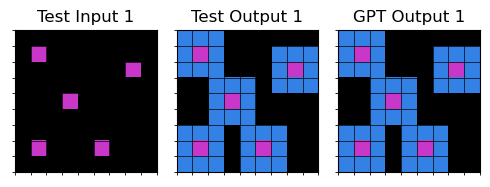

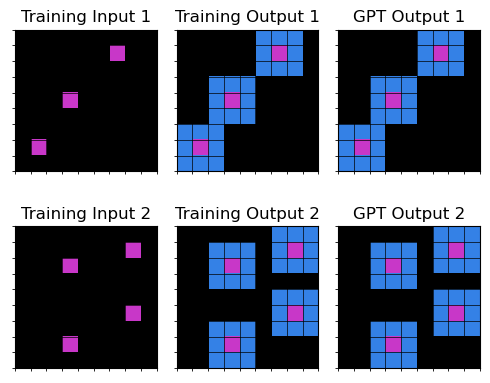

In [26]:
task_name = file_names_train[index]
json_task = copy.deepcopy(myjson_train[task_name])

code_string = 'None'
error_msg = 'None'
overall_pattern = 'None'
correct = True
test_correct = False
prev_transform = lambda x: x

# do the loop
for i in range(num_trials):
    # Do some json processing
    for each in json_task['train']+json_task['test']:
        # convert to string representation
        for field in ['input', 'output', 'code_output']:
            if field in each: 
                each[field] = array_to_string(each[field])
                # if we want to treat no cells as a color
                if missing_color:
                    each[field] = replace(each[field],[['.']],[['j']])
        each['input_grid_size'] = get_size(each['input'])
        if object_view: each['input_objects'] = get_objects(each['input'], diag=diag, by_color = by_color, by_row = by_row, by_col = by_col, multicolor = multicolor, more_info = more_info)
        if pixel_view: each['input_pixel_coords'] = get_pixel_coords(each['input'])
        each['output_grid_size'] = get_size(each['output'])
        if object_view: each['output_objects'] = get_objects(each['output'], diag=diag, by_color = by_color, by_row = by_row, by_col = by_col, multicolor = multicolor, more_info = more_info)
        if pixel_view: each['output_pixel_coords'] = get_pixel_coords(each['output'])
        if 'code_output' in each:
            each['code_output_grid_size'] = get_size(each['code_output'])
            if object_view: each['code_output_objects'] = get_objects(each['code_output'], diag=diag, by_color = by_color, by_row = by_row, by_col = by_col, multicolor = multicolor, more_info = more_info)
            if pixel_view: each['code_output_pixel_coords'] = get_pixel_coords(each['code_output'])
    new_json_task = copy.deepcopy(json_task['train'])
    # do not need to show input if we are continuing from code_output
    for each in new_json_task:
        if 'code_output' in each:
            each['input']=copy.deepcopy(each['code_output'])
            del each['code_output']
            if 'input_grid_size' in each: 
                each['input_grid_size']=copy.deepcopy(each['code_output_grid_size'])
                del each['code_output_grid_size']
            if 'input_objects' in each: 
                each['input_objects']=copy.deepcopy(each['code_output_objects'])
                del each['code_output_objects']
            if 'input_pixel_pos' in each: 
                each['input_pixel_coords']=copy.deepcopy(each['code_output_pixel_coords'])
                del each['code_output_pixel_coords (row,col)']
        if hide_grid:
            each['input']='not_shown'
            each['output']='not_shown'
            
    user_prompt = 'All coordinates are given as (row,col). Use get_size(grid) to return (len(grid),len(grid[0])).'
    if object_view:
        user_prompt += f'\nTo get objects, use get_objects(diag={diag},by_row={by_row},by_col={by_col},by_color={by_color},multicolor={multicolor},more_info={more_info})\n'
        
    user_prompt += str(new_json_task).replace(', ',',').replace(' ','')

    if error_msg != 'None':
        user_prompt += '\nPrevious Code: '+code_string
        user_prompt += '\nError message: ' + error_msg
        user_prompt += f'\nPrevious overall pattern: {overall_pattern}.\n\nYour code had compilation errors. Correct it.'

    elif not correct:
        user_prompt += f'''\nUse the transform_grid function to get the right relation from 'input' to 'output' '''
        prev_transform = copy.deepcopy(transform_grid)

    res = strict_output(system_prompt = preamble, user_prompt = user_prompt, output_format = output_format, model = model, prompt_only = manual)
    if manual:
        clear_output()
        html_fig = plot_2d_grid(json_task)
        print(res)
        gpt = input("\n\n\nEnter the GPT output")
        
        try:
            res = str(gpt)

            # do some regex to remove unwanted single aprostrophes
            res = res.replace("'", '"')

            # replace any color name enclosed in double quotation marks to single quotation marks
            pattern = r'"([^\s"]+)"'
            res = re.sub(pattern, r"'\1'", res)

            # replace only single aprostrophe at the end of a word
            pattern = r'\b(?<!")(\w+)"\s'
            res = re.sub(pattern, r'\1 ', res)

            # add back double quotes to header names
            for key in list(output_format.keys()):
                pattern = fr"'({key})'"
                res = re.sub(pattern, r'"\1"', res)

            # ensure that we don't replace away aprostophes in text 
            res = re.sub(r"(\w)\"(\w)", r"\1'\2", res)

            # ensure that everything in python_program is substituted away
            pattern = r'"python_program"\s*:\s*"([^@]+)"}$'
            res = re.sub(pattern, lambda m: '"python_program": "'+m.group(1).replace('"', "'")+'"}', res)

            # replace any characters with a backslash away, except \n and \t
            pattern = r"(\\[^nt])"
            res = re.sub(pattern, "", res)

            # replace newline and tabs
            res = res.replace("\n", "\\n").replace("\t", "\\t")

            res = json.loads(res)  
        
            overall_pattern = res['overall_pattern']
        except Exception as e:
            print('Incorrect json:', res)
        
    ## check if code works
    error_msg = ''
    try:
        # test out if function compiles
        exec(res["python_program"])
        code_string = res["python_program"]
        # test out if function works with one grid
        for each in json_task['train']:
            output = transform_grid(prev_transform(copy.deepcopy(each['input'])))
        for each in json_task['test']:
            output = transform_grid(prev_transform(copy.deepcopy(each['input'])))
        # check if resulting output is a 2D array
        assert len(np.array(output).shape) == 2
        assert isinstance(output[0], list)
        assert isinstance(output[0][0], str)

    except Exception as e:
        exception_traceback = StringIO()
        traceback.print_exc(file=exception_traceback)
        error_msg = exception_traceback.getvalue()
        print('Code did not work')
        print(error_msg)

    else:
        error_msg = 'None'
    
    ## check if code works
    if error_msg == 'None':
        correct = True
        for each in json_task['train']:
            each['code_output'] = replace(replace(transform_grid(prev_transform(copy.deepcopy(each['input']))),[['$']],[['.']]),[['j']],[['.']])
            
            if each['code_output'] != each['output']: correct = False
    else:
        correct = False
    
    # if works, move on to test case
    if correct: 
        test_correct = True
        for each in json_task['test']:
            each['code_output'] = replace(replace(transform_grid(prev_transform(copy.deepcopy(each['input']))),[['$']],[['.']]),[['j']],[['.']])
            if each['code_output'] != each['output']: test_correct = False

        if test_correct:
            print('Test case(s) passed!')
        else:
            print('Incorrect solution')
        print(f'Run {i}', res)
        html_fig = plot_2d_grid(json_task)
        write_file(html_fig, task_name, res, error_msg, correct, test_correct, i, expert_types)
        break

    print(f'Run {i}', res)
    html_fig = plot_2d_grid(json_task)
    write_file(html_fig, task_name, res, error_msg, correct, test_correct, i, expert_types)

# Visualize output
- Used after the above loop terminates to visualize the output
- also can visualize from the .html file produced

ARC Training Set index 9
ARC Task name 4258a5f9.json

Training Set Status: True
Test Set Passed: True

reflection: The output grid is always the same size as the input grid. The letter 'e' from the input grid always remains at the same position in the output grid. Around each 'e', a square of 'a's is formed, taking up an area of 3x3, with 'e' at the center.
pixel_changes: The pixels of 'e' dont move from the input to the output grid. New pixels of 'a' are added around each 'e', forming a square shape.
object_changes: In the input grid, there are only single pixels of 'e'. In the output grid, there are also squares of 'a' around each 'e'. The size, shape, position, value, and cell count of the 'e' objects dont change. New 'a' objects are created around each 'e', with a size of 3x3, a square shape, and a cell count of 8.
helper_functions: get_pixel_coords, fill_rect, fill_value
overall_pattern: For each 'e' in the input grid, a square of 'a's is formed around it in the output grid, with 

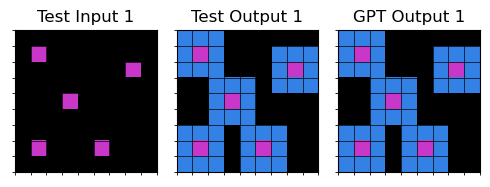

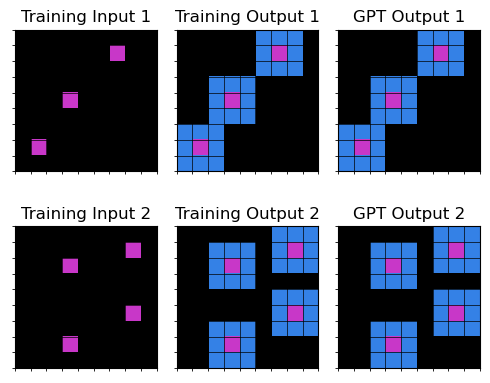

In [27]:
index = good_index_train[ref_value]
task_name = file_names_train[index]
print('ARC Training Set index', index)
print('ARC Task name', task_name)
print()
print('Training Set Status:', correct)
print('Test Set Passed:', test_correct)
print()
for key, value in res.items():
    print(f'{key}: {value}')

html = plot_2d_grid(json_task)